Welcome to our Project 2 Notebook by Team Pandamonium - Luna Amador, Joshua Varughese and Ellen Wang

This project aims to use socio-economic factors and other identified explanatory variables to predict the proportion of car sales taken up by different car size categories, including small, midsize and large categories. This will be achieved by developing 3 linear regression models and will allow car manufacturers to predict what size cars they should focus on developing based on the factors chosen below.

In [1]:
# Import 3rd party libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from requests import get
from functools import reduce

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In this section we scrape the GoodCarBadCar website to produce tables of models and monthly car sales from which we can form our dataset

In [2]:
#these lists allow the loop below to accommodate the differences between websites for each year of carsales
years = [2019, 2020, 2021]
ranges = [594, 1, 580]

#a list to store the scraped web data for car sales of each year
carsaleslist = []

for index, year in enumerate(years):
    response = get('https://www.goodcarbadcar.net/{year}-canada-vehicle-sales-figures-by-model/' .format(year = year))
    html_soup = BeautifulSoup(response.text, 'html.parser')
    table_rows = html_soup.find_all('tr')[ranges[index]:-1] #excludes the sum row

    #lists to store the important data scraped from each webpage
    model_names = []
    january = []
    february = []
    march = []
    april = []
    may = []
    june = []
    july = []
    august = []
    september = []
    october = []
    november = []
    december = []

    # iterate through each row in the table
    for row in table_rows:
        # use certain tags positions and/or subtags, then extract the text, and use .strip() to remove leading whitespace, and then add them to the corresponding to list
        model_name = row.find_all('td')[0].text.strip()
        model_names.append(model_name)

        jan_sum = row.find_all('td')[1].text.strip()
        january.append(int(jan_sum.replace(',','')))

        feb_sum = row.find_all('td')[2].text.strip()
        february.append(int(feb_sum.replace(',','')))

        mar_sum = row.find_all('td')[3].text.strip()
        march.append(int(mar_sum.replace(',','')))

        apr_sum = row.find_all('td')[4].text.strip()
        april.append(int(apr_sum.replace(',','')))

        may_sum = row.find_all('td')[5].text.strip()
        may.append(int(may_sum.replace(',','')))

        jun_sum = row.find_all('td')[6].text.strip()
        june.append(int(jun_sum.replace(',','')))

        jul_sum = row.find_all('td')[7].text.strip()
        july.append(int(jul_sum.replace(',','')))

        aug_sum = row.find_all('td')[8].text.strip()
        august.append(int(aug_sum.replace(',','')))

        sep_sum = row.find_all('td')[9].text.strip()
        september.append(int(sep_sum.replace(',','')))

        oct_sum = row.find_all('td')[10].text.strip()
        october.append(int(oct_sum.replace(',','')))

        nov_sum = row.find_all('td')[11].text.strip()
        november.append(int(nov_sum.replace(',','')))

        dec_sum = row.find_all('td')[12].text.strip()
        december.append(int(dec_sum.replace(',','')))

    #create a dataframe containing columns corresponding to the lists generated above
    carsaleslist.append(pd.DataFrame({'make_and_model': model_names, '{year}-01-01'.format(year = year): january,
                              '{year}-02-01'.format(year = year): february, '{year}-03-01'.format(year = year): march,'{year}-04-01'.format(year = year): april,
                              '{year}-05-01'.format(year = year):may, '{year}-06-01'.format(year = year):june, '{year}-07-01'.format(year = year):july,'{year}-08-01'.format(year = year):august,
                              '{year}-09-01'.format(year = year): september, '{year}-10-01'.format(year = year): october,
                              '{year}-11-01'.format(year = year): november,'{year}-12-01'.format(year = year): december}).replace("-"," "))

#compile the list of dataframes into a single dataframe, only keeping the makes and models contained in all years
car_sales = reduce(lambda left, right:
               pd.merge(left, right, on = 'make_and_model', how = 'outer'),
               carsaleslist)

This section is where we merge the Car Model list with the car sales dataframe to allow us to assign a body-type to each of the car models that we have sales data for

In [3]:
'''This section of the code will merge the car_sales data with the car_models data, such that every car make and model
sold will be placed in a car body category'''
#Read the car model csv file containing the body size category of many different car makes and models
car_models = pd.read_csv("Car_Model_List.csv")
#read a hand-generated csv containing the models missing from the main model list but contained in the car_sales dataframe
missing_car_models = pd.read_csv("missing_models.csv")

#create a list of the months considered in this analysis
months_for_analysis = ['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01','2019-07-01',
                       '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
                       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
                       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
                       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
                       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01']


def make_and_model_canonicalization(car_sales, car_models,missing_car_models):
    '''Canonicalizes car_sales such that the elements in the make_and_model column of both dataframes matches
        input:
        car_sales --> A dataframe containing monthly car sales for different makes and models
        car_models --> A dataframe containing different car makes and models and their body

        returns:
        car_models dataset with modified strings in the make_and_model column to match the car_sales column canonicalization
        car_sales dataset with modified strings in the make_and_model column to match the car_models column canonicalization
        '''
    car_make_list = car_models["Make"].astype(str).str.lower().str.replace("-benz","").unique().tolist()
    # Creating a single column for make and model, to match the format of the car_sales column
    car_models["make_and_model"] = car_models["Make"].astype(str).str.lower() + " " + car_models["Model"].astype(str).str.lower().replace(car_make_list," ",regex=True)

    # Removing duplicates since the same make and model is present for multiple years in the car_models dataframe
    car_models = car_models.loc[:, ["make_and_model", "Category"]].drop_duplicates().apply(lambda x: x.replace("-"," ",regex=True)
                                                                                           .replace("/"," ",regex=True)
                                                                                           .replace("benz"," ",regex=True)
                                                                                           .replace("bolt ev","bolt",regex=True)
                                                                                           .replace("passenger"," ",regex=True)
                                                                                           .replace("crew cab"," ",regex=True)
                                                                                           .replace("extended cab"," ",regex=True)
                                                                                           .replace("regular cab"," ",regex=True)
                                                                                           .replace("1500 double cab"," ",regex=True)
                                                                                           .replace("2500 hd double cab"," ",regex=True)
                                                                                           .replace("2500 cargo"," ",regex=True)
                                                                                           .replace("2500 hd"," ",regex=True)
                                                                                           .replace("3500 hd"," ",regex=True)
                                                                                           .replace("1500"," ",regex=True)
                                                                                           .replace("fuel cell","fcv",regex=True)
                                                                                           .replace("electric"," ",regex=True)
                                                                                           .replace("boxster"," ",regex=True)
                                                                                           .replace("defender 90","defender",regex=True)
                                                                                           .replace("slc class","slc",regex=True))
    car_models["make_and_model"] = car_models["make_and_model"] \
        .apply(lambda x: x[:12] if ("ford transit" in x and "ford transit connect" not in x) else x)\
        .apply(lambda x: "ford f series" if "ford f150" in x else x)\
        .apply(lambda x: "ford e series" if "ford e350" in x else x)

    car_sales["make_and_model"] = car_sales["make_and_model"].str.lower()
    car_models["Category"] = car_models["Category"].replace("1992","",regex=True).replace("2020","",regex=True)

    car_sales = car_sales.apply(lambda x: x.replace("-", " ",regex=True)
                                .replace("/", " ",regex=True)
                                .replace("lr4"," ",regex=True)
                                .replace("impreza wrx","wrx",regex=True)
                                .replace("fr s"," ",regex=True)
                                .replace("benz"," ",regex=True)
                                .replace("etron","e tron",regex=True)
                                .replace("tuscon","tucson",regex=True)
                                .replace("mazda3","mazda 3",regex=True)
                                .replace("mazda6","mazda 6",regex=True)
                                .replace("nautilus"," ",regex=True)
                                .replace("90 series","s90",regex=True)
                                .replace("60 series","s60",regex=True)
                                .replace("40 series","s40",regex=True)
                                .replace("pickup"," ",regex=True)
                                .replace("family"," ",regex=True)
                                .replace("glk class"," ",regex=True)
                                .replace("gl gls class","gls",regex=True)
                                .replace("gle class","gle",regex=True)
                                .replace("slc class","slc",regex=True)
                                .replace("e   cls class","cls",regex=True))

    #Removing additional spaces in the strings in the male_and_model column
    car_sales["make_and_model"] = car_sales["make_and_model"].apply(lambda x:' '.join(x.split()))
    car_models["make_and_model"] = car_models["make_and_model"].apply(lambda x:' '.join(x.split()))
    car_models = pd.concat([car_models, missing_car_models], axis=0)

    return car_sales,car_models

#Merging car_sales and car_models by make and model
car_sales, car_models = make_and_model_canonicalization(car_sales, car_models,missing_car_models)
car_sales_by_size = car_sales.merge(right=car_models,
                                    how='outer',
                                    on='make_and_model')

#Filters out the vehicle makes and models that were not sold in any month from 2019-2021 in Canada
car_sales_by_size = car_sales_by_size[~car_sales_by_size[months_for_analysis].isna().all(1) | (car_sales_by_size[months_for_analysis]==0).all(1)]

#Drop duplicate rows
car_sales_by_size = car_sales_by_size.drop_duplicates(['make_and_model'])

#put car model, car sales, and merged car sales list  to csv
car_models.to_csv('Car_Model_List_updated.csv', encoding='utf-8', index=False)
car_sales.to_csv('Car_Sales_2019_2021.csv', encoding='utf-8', index=False)
car_sales_by_size.to_csv('Merged Car Sales List.csv', encoding='utf-8', index=False)

#Now combining all the data into one table

#categorizing all combinations of car size category
small_cars=["Coupe","Hatchback","Convertible",'Convertible, Sedan','Coupe, Sedan, Convertible',
            'Coupe, Convertible','Convertible, Sedan, Coupe','Sedan, Hatchback','Hatchback, Sedan',
            'Hatchback, Sedan, Coupe','Convertible, Coupe, Hatchback']
midsize_cars=["SUV","Sedan","Wagon",'Wagon, Sedan']
large_cars=["Pickup","Van","Minivan",'Van Minivan']

#categorizing the sizes
car_sales_by_size['Category'] = car_sales_by_size['Category']\
    .apply(lambda x: 'small' if (x in small_cars) else x)\
    .apply(lambda x: 'midsize' if (x in midsize_cars) else x)\
    .apply(lambda x: 'large' if (x in large_cars) else x)

#create a new dataframe with categorized % columns
car_size_category = car_sales_by_size.groupby('Category').agg(sum)


#create monthly sums list that represents the total sales for each month of different car sizes
monthly_sums = list(car_sales_by_size.sum(axis = 0)[1:-1])

#calculate % proportion sales for each size of car per month
car_size_category = (car_size_category/monthly_sums).T.rename(columns={"small": "prop_small",
                                                                       "midsize": "prop_midsize",
                                                                       "large": "prop_large"})


Here we add all the other features we consider to the dataframe, including:
- monthly employment stats (with corrected units as per website indication
- monthly oil prices
- monthly transit ridership stats
- monthly dollar exchange rate (with respect to USD)
- monthly gdp for canada
- monthly interest rate from the bank of canada

In [4]:
#convert to datetime index full month name and full year
car_size_category.index = pd.to_datetime(car_size_category.reset_index()['index'])

#add the monthly total sales figures as a feature
car_size_category['Total Monthly Car Sales'] = monthly_sums
car_size_category.to_csv('%_category.csv', encoding='utf-8', index=False)


#add the monthly employment stats units corrected (x1000) and datetime index set as a feature
employment_stats = pd.read_csv("monthly_employment_stats_2019-2021.csv").set_index('Labour force characteristics')\
    .T.astype(str).replace(',','',regex = True).astype(float)
employment_stats.index = employment_stats.reset_index()['index'].apply(lambda x: datetime.strptime(x,"%b-%y"))
employment_stats[['Unemployment rate','Participation rate','Employment rate']]= employment_stats[['Unemployment rate','Participation rate','Employment rate']]/100
employment_stats[employment_stats.columns.difference(['Unemployment rate','Participation rate','Employment rate'])]\
    =employment_stats[employment_stats.columns.difference(['Unemployment rate','Participation rate','Employment rate'])]*1000


#Add the monthly oil prices units corrected (cents to dollars) and datetime index set as a feature
oil_prices = pd.read_csv("monthly_oil_prices_2019-2021.csv").rename(columns={"VALUE": "Average Monthly Oil Price"})\
                 .set_index('REF_DATE').loc[:,'Average Monthly Oil Price'].astype(float)/100
oil_prices.index = oil_prices.reset_index()['REF_DATE'].apply(lambda x: datetime.strptime(x,"%b-%y"))


#add the monthly transit ridership units corrected (x1 mill) and datetime index set as a feature
transit_ridership = pd.read_csv("monthly_transit_ridership_2019-2021.csv").rename(columns={"VALUE": "transit_ridership"})\
                        .set_index('REF_DATE').loc[:,'transit_ridership'].astype(float)*1000000
transit_ridership.index = transit_ridership.reset_index()['REF_DATE'].apply(lambda x: datetime.strptime(x,"%b-%y"))


#add the monthly dollar exchange rate (USD-CAD) datetime index set as a feature
der_usd_cad = pd.read_csv("monthly_der_2019-2021.csv").rename(columns={"FXMUSDCAD": "Dollar Exchange Rate"})\
                        .set_index('date').loc[:,'Dollar Exchange Rate'].astype(float)
der_usd_cad.index = der_usd_cad.reset_index()['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d"))


#add the monthly gdp (in 2012 dollars) units correct and datetime index set as a feature
gdp = pd.read_csv("monthly_oil_prices_2019-2021.csv").rename(columns={"VALUE": "gdp"})\
                 .set_index('REF_DATE').loc[:,'gdp'].astype(float)*1000000
gdp.index = gdp.reset_index()['REF_DATE'].apply(lambda x: datetime.strptime(x,"%b-%y"))


#add the monthly interest rates as a feature
interest_rates = pd.read_csv('monthly_interest_rates_canada.csv')
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])
interest_rates.set_index('Date', drop = True, inplace= True)

#merging all dataframes into using datetime indices
total_table = pd.concat([car_size_category,employment_stats,oil_prices,transit_ridership, der_usd_cad, gdp, interest_rates], axis=1)
total_table.to_csv('Merged Total Table.csv', encoding='utf-8', index=False)

#add the season of the year as a feature
#This dictionary maps each month to a season (Canadian Seasons) where 1 is Summer, 2 is Fall, 3 is Winter and 4 is Spring
ref_seasons = {12:3, 1:3, 2:3,
           3:4, 4:4, 5:4,
           6:1, 7:1, 8:1,
           9:2, 10:2,11:2}
total_table['Season'] = total_table.index.month
total_table['Season'] = total_table['Season'].apply(lambda x : ref_seasons[x])

Preliminary Exploratory Data Analysis - Looking into inter-correlations between features

In [ ]:
#Plot and initial correlation heatmap of all included variables to identify which ones to remove (highly inter-correlated variables)
correlation=total_table.corr()
plt.figure(figsize=(18,12))
plt.title('Correlation Heatmap of Vehicle Sales in Canada Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

From the heatmap above, it is clear that some features are highly correlated with each other. The features that stand out are the socio-economic indicators that relate to job status (i.e. employment, employment rates, unemployment). This makes sense because these indicators are all tied to each other (i.e. unemployment rate is directly tied to employment rate etc.). For this reason, selected features will be excluded.

In [5]:
features_to_exclude = [
                       'Total Monthly Car Sales',
                       'Population',
                       'Labour force',
                       'Employment',
                       'Full-time employment',
                       'Part-time employment',
                       'Unemployment',
                       'Unemployment rate',
                       'Participation rate',
                       #'Employment rate',
                       #'Average Monthly Oil Price',
                       'transit_ridership',
                       #'Dollar Exchange Rate',
                       'gdp',
                       #'Interest Rate',
                       #'Season'
                       ]
model_table = total_table.drop(features_to_exclude, axis = 1)

New feature correlation visualizations after feature selection

This section produces several graphs

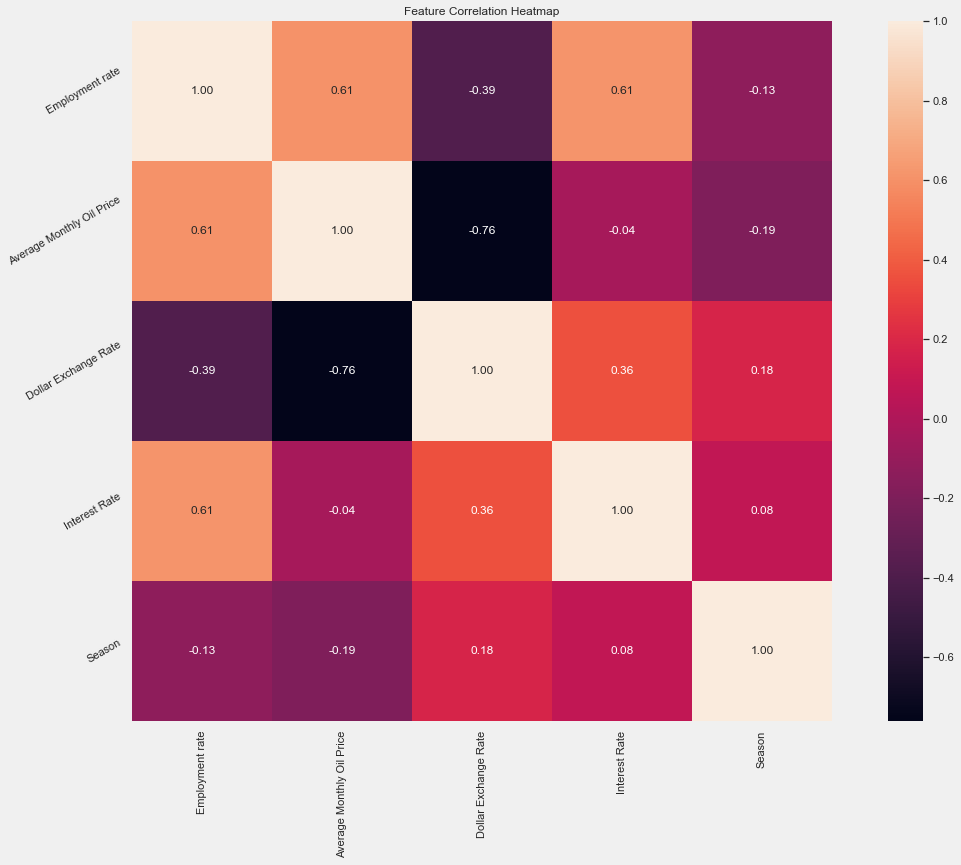

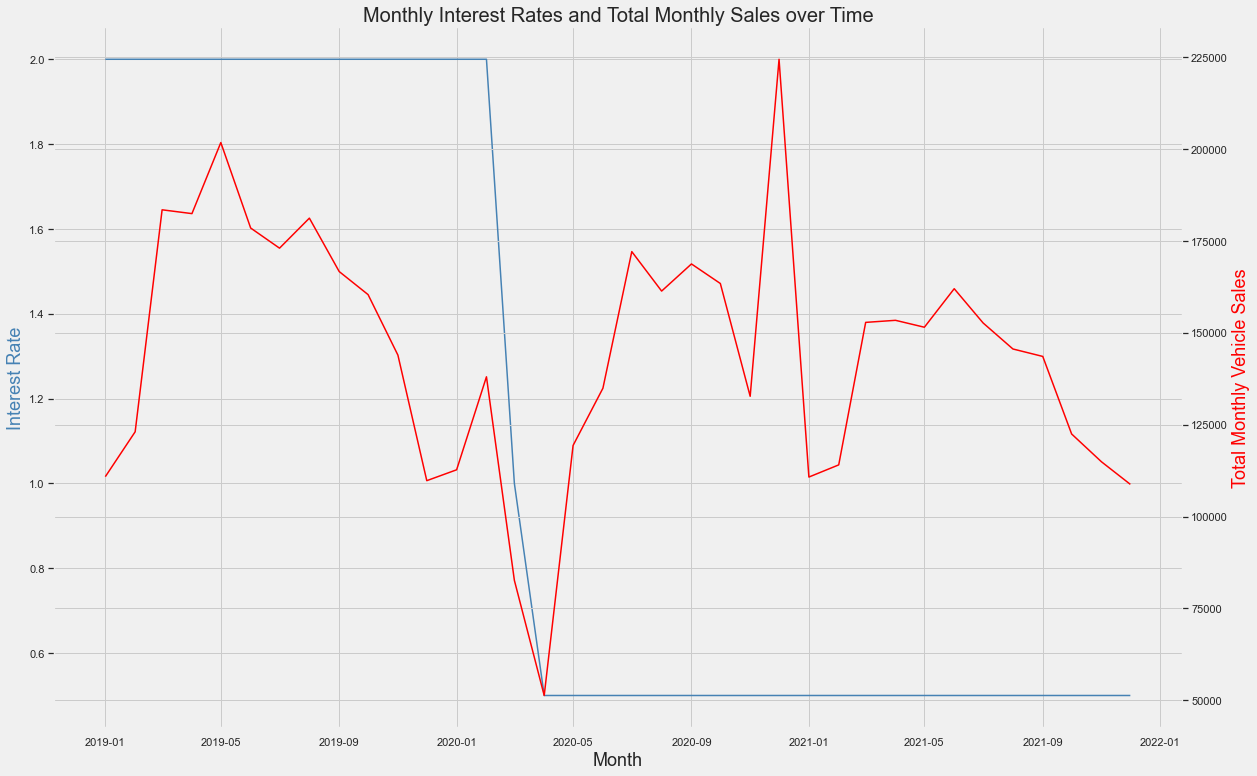

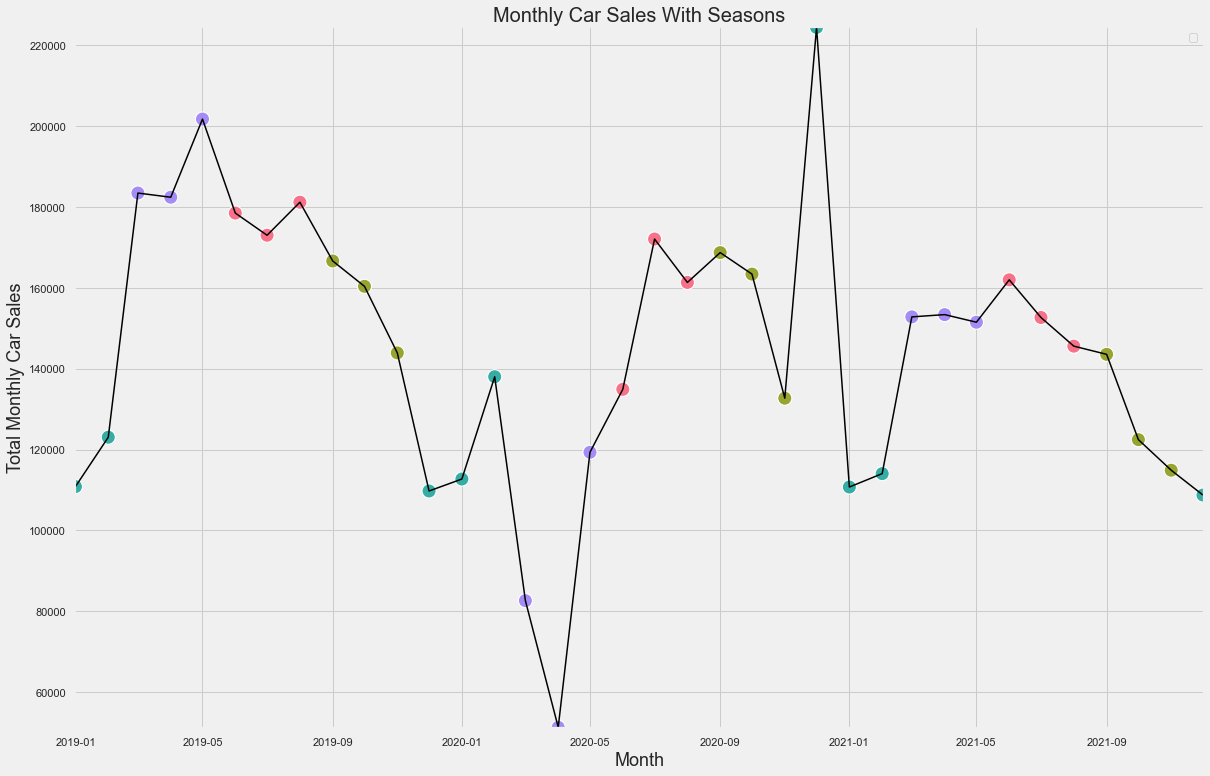

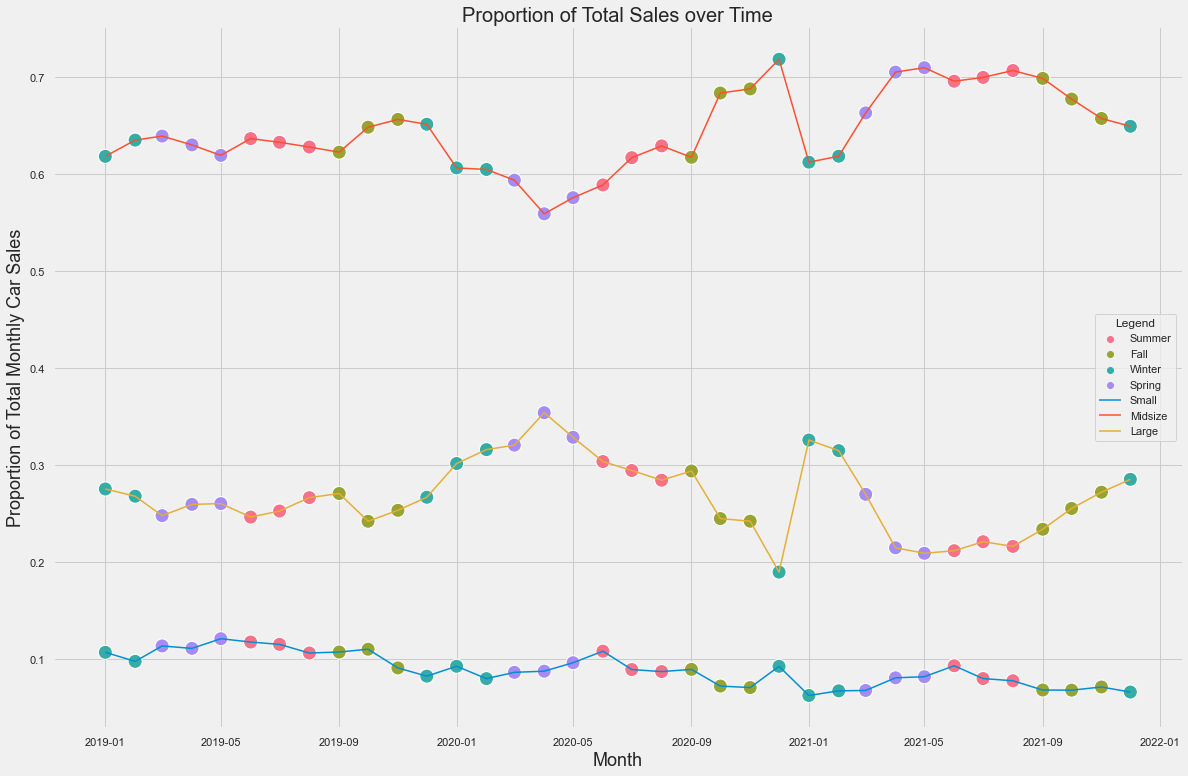

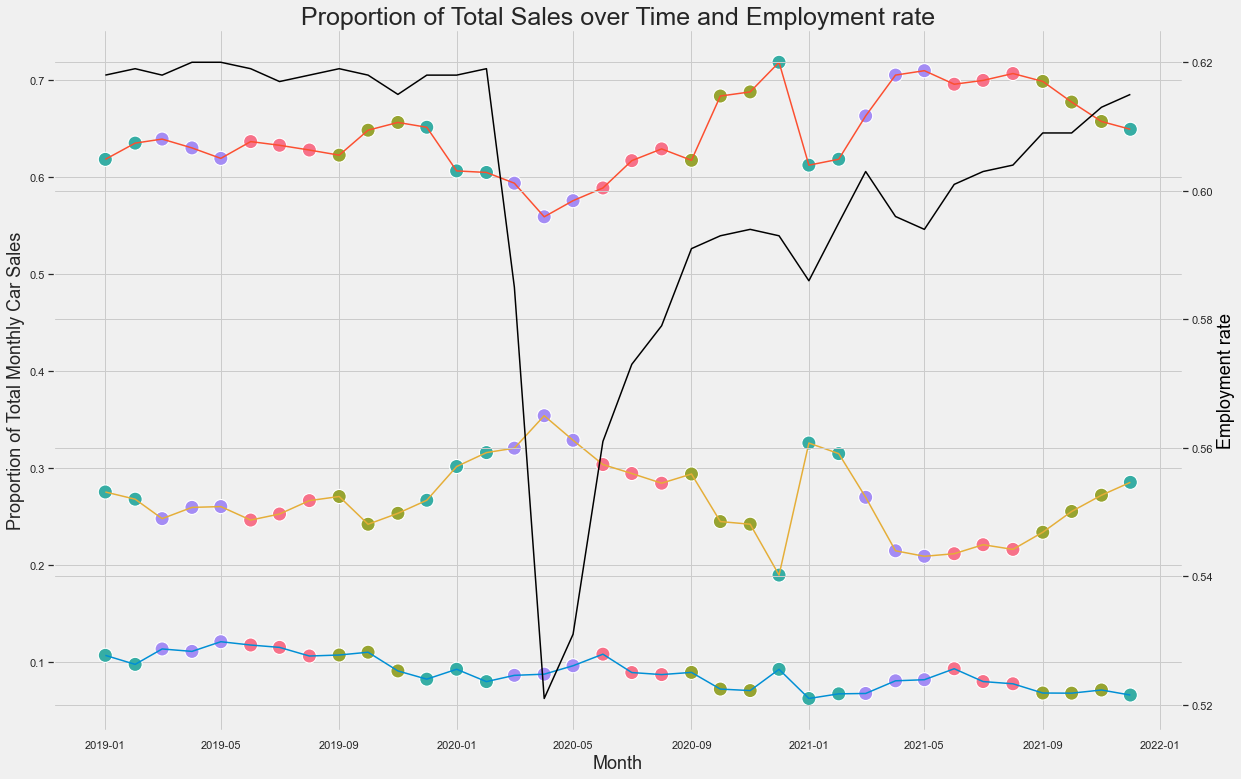

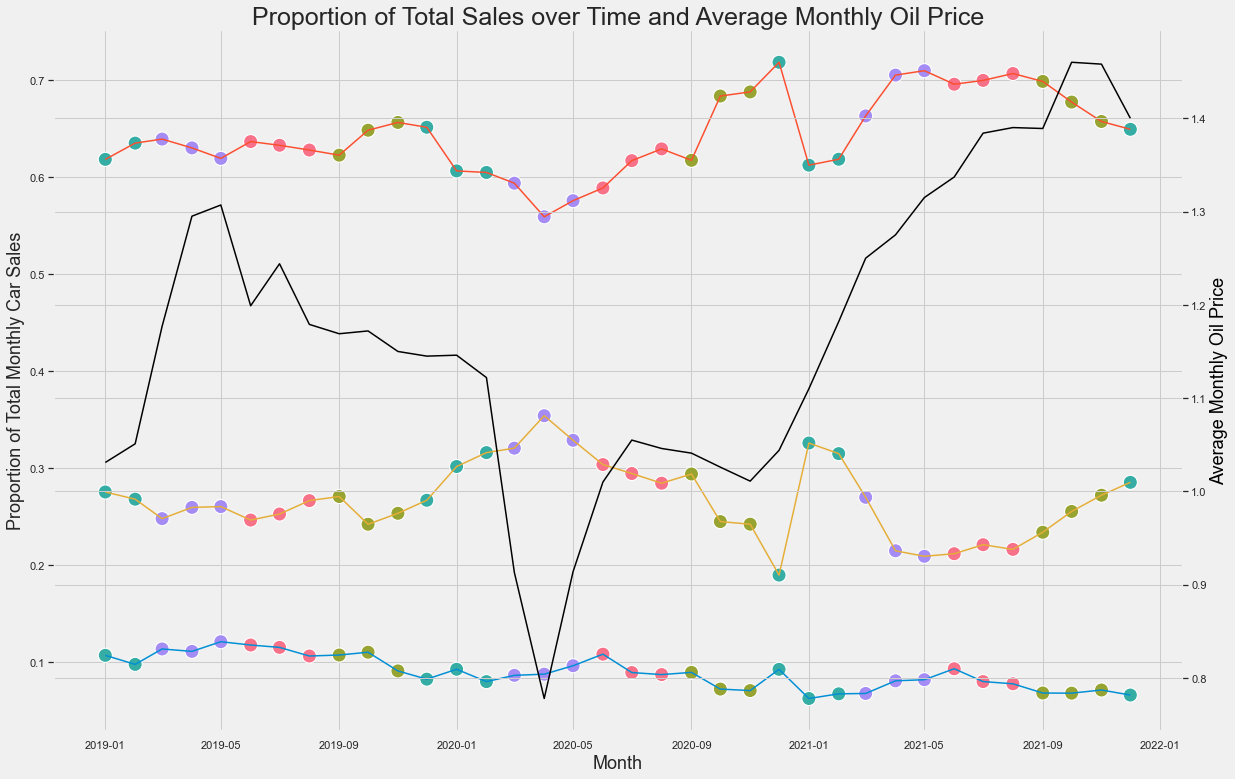

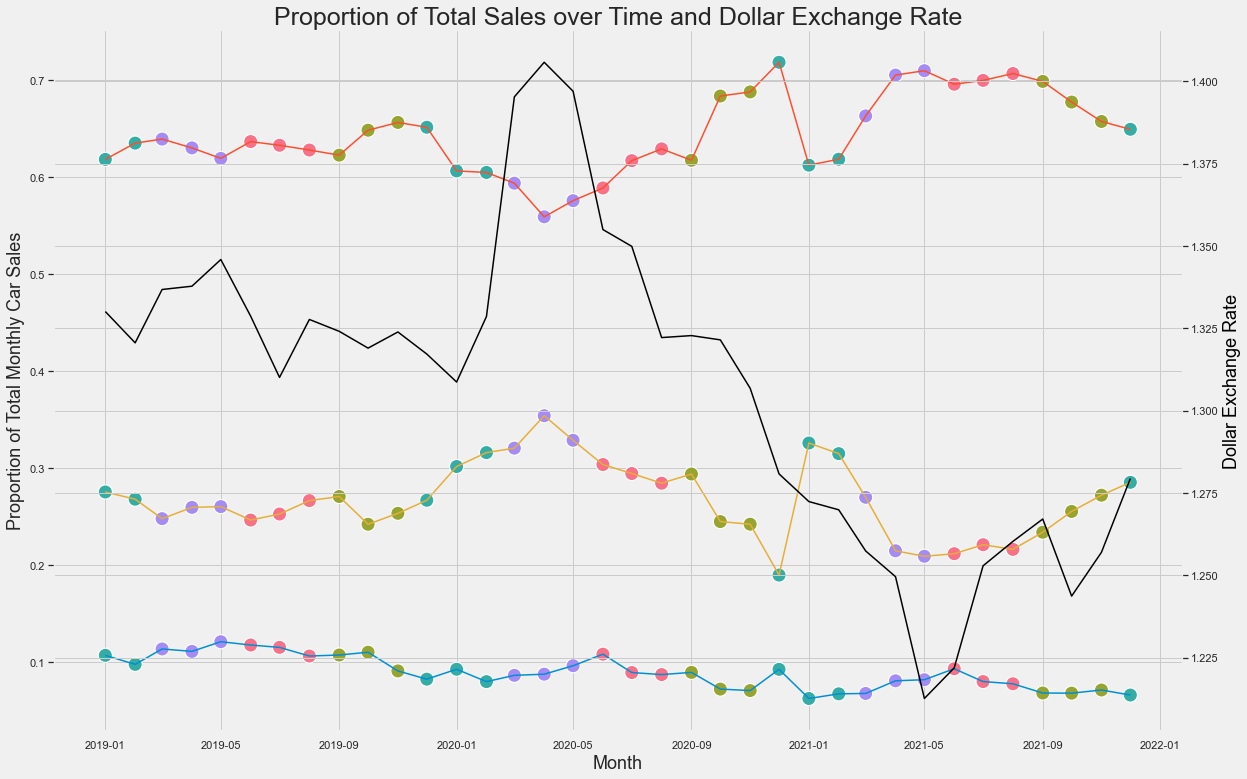

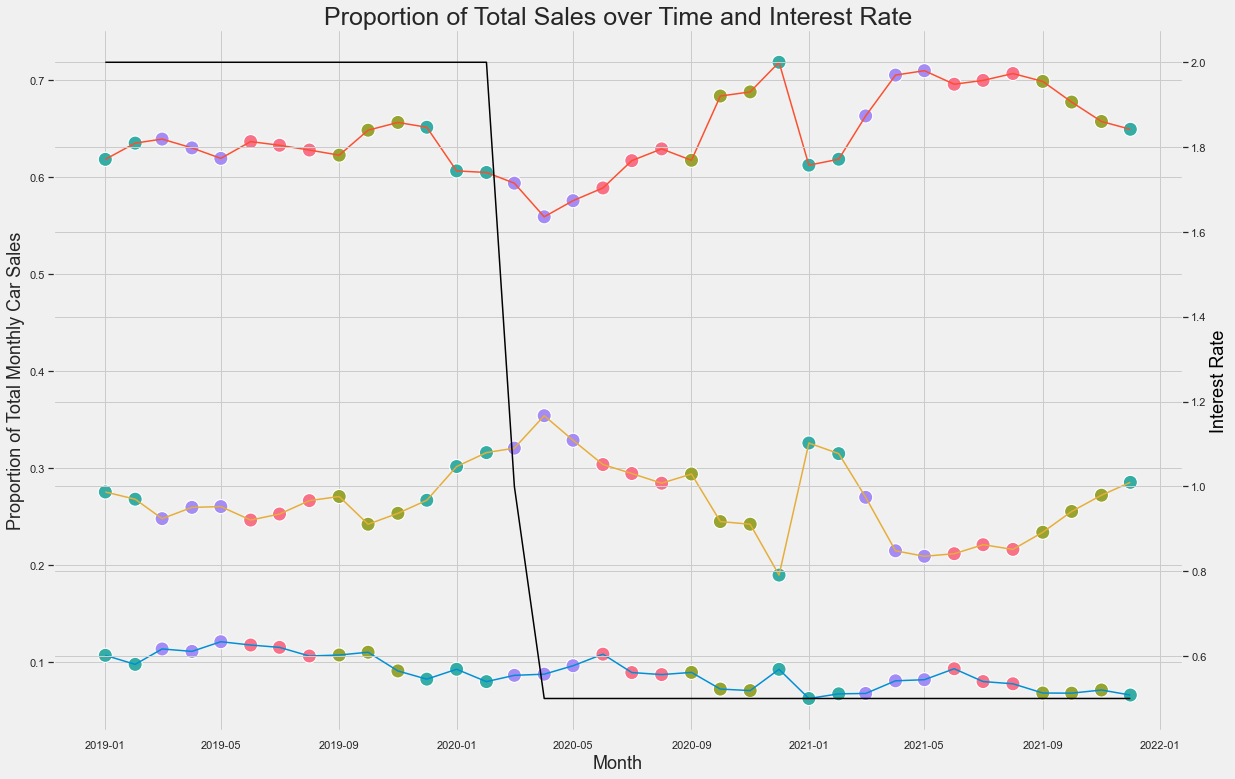

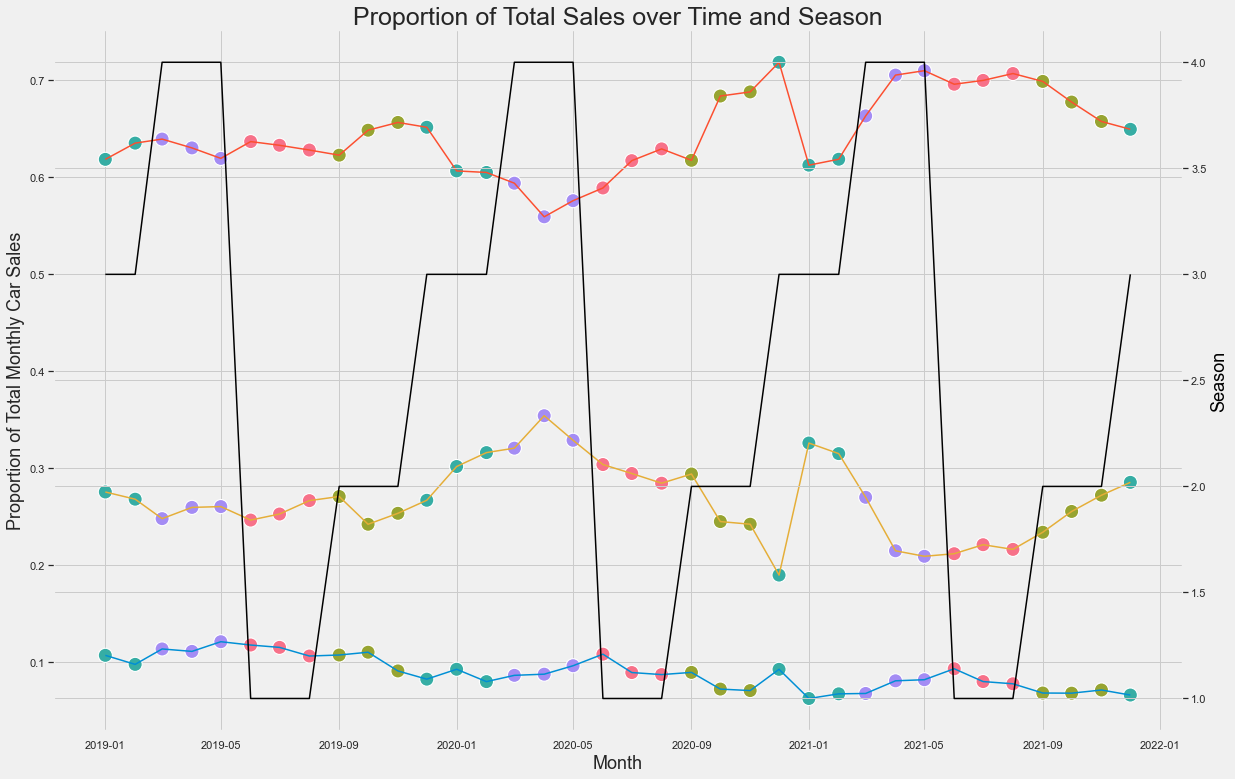

In [7]:
#Plot a correlation heatmap between the selected variables
correlation=model_table.drop(['prop_small','prop_midsize','prop_large'],axis=1).corr()
plt.figure(figsize=(18,12))
plt.title('Feature Correlation Heatmap')
ax=sns.heatmap(correlation,square=True,annot=True,fmt='.2f',linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=30)
plt.show()

#Plot interest rates over time
plt.figure(figsize=(18,12))
plt.title('Monthly Interest Rates and Total Monthly Sales over Time',fontsize=20)
ax=sns.lineplot(x=total_table.index,y=total_table['Interest Rate'],color='steelblue')
ax.set_xlabel('Month',fontsize=18)
ax.set_ylabel('Interest Rate',fontsize=18,color='steelblue')

#Plot total monthly vehicle sales over time on the same plot
ax2=ax.twinx()
sns.lineplot(x=total_table.index,y=total_table['Total Monthly Car Sales'],ax=ax2,color='red')
ax2.set_ylabel('Total Monthly Vehicle Sales',fontsize=18,color='red')
plt.show()

#Plot sales over time with respect to season
#1 is summer, 2 is fall, 3 is winter, 4 is spring
plt.figure(figsize=(18,12))
plt.xlim(total_table.index.min(),total_table.index.max())
plt.ylim(total_table['Total Monthly Car Sales'].min(),total_table['Total Monthly Car Sales'].max())
plt.title('Monthly Car Sales With Seasons',fontsize=20)
ax=sns.scatterplot(x=total_table.index,y=total_table['Total Monthly Car Sales'],hue=total_table['Season'],markers='o',s=200,palette=sns.color_palette("husl",4))

#adds a line over dot markers for the seasons plot
sns.lineplot(x=total_table.index,y=total_table['Total Monthly Car Sales'],color='black',ax=ax)
ax.set_xlabel('Month',fontsize=18)
ax.set_ylabel('Total Monthly Car Sales',fontsize=18)
h,l=ax.get_legend_handles_labels()
plt.legend(h[12:15],l[12:15])
plt.show()

#Plot proportion of sales over time with respect to seasons
plt.figure(figsize=(18,12))
plt.title('Proportion of Total Sales over Time',fontsize=20)
ax=sns.scatterplot(x=total_table.index,y=total_table['prop_small'],hue=total_table['Season'],palette=sns.color_palette("husl",4),s=200)
sns.scatterplot(x=total_table.index,y=total_table['prop_midsize'],hue=total_table['Season'],palette=sns.color_palette("husl",4),s=200,ax=ax)
sns.scatterplot(x=total_table.index,y=total_table['prop_large'],hue=total_table['Season'],palette=sns.color_palette("husl",4),s=200,ax=ax)
ax.set_xlabel('Month',fontsize=18)
ax.set_ylabel('Proportion of Total Monthly Car Sales',fontsize=18)

#adds a line over the dot markers for each of the proportions
sns.lineplot(x=total_table.index,y=total_table['prop_small'],label='Small',ax=ax)
sns.lineplot(x=total_table.index,y=total_table['prop_midsize'],label='Midsize',ax=ax)
sns.lineplot(x=total_table.index,y=total_table['prop_large'],label='Large',ax=ax)

#updates the legend with the correct seasons
#3 is winter,4 is spring,1 is summer,2 is fall
h,l=ax.get_legend_handles_labels()
lbls=['Summer','Fall','Winter','Spring','Small','Midsize','Large']
plt.legend(h[8:15],lbls,title='Legend')


#this loop plots each explanatory variable over the monthly proportions graph (on separate y-axes)
iter = 0
for column in model_table.columns:
    #this iterable skips over the first few plots in the dataset because they are irrelevant (proportions, not explanatory variables)
    iter += 1
    if iter < 4 : continue
    plt.figure(figsize=(18,12))
    plt.title('Proportion of Total Sales over Time and {}'.format(column),fontsize=25)
    ax=sns.scatterplot(x=model_table.index,y=model_table['prop_small'],hue=model_table['Season'],palette=sns.color_palette("husl",4),s=200)
    sns.scatterplot(x=model_table.index,y=model_table['prop_midsize'],hue=model_table['Season'],palette=sns.color_palette("husl",4),s=200,ax=ax)
    sns.scatterplot(x=model_table.index,y=model_table['prop_large'],hue=model_table['Season'],palette=sns.color_palette("husl",4),s=200,ax=ax)
    ax.set_xlabel('Month',fontsize=18)
    ax.set_ylabel('Proportion of Total Monthly Car Sales',fontsize=18)

    #adds a line over the markers for each proportion
    sns.lineplot(x=model_table.index,y=model_table['prop_small'],label='Small',ax=ax)
    sns.lineplot(x=model_table.index,y=model_table['prop_midsize'],label='Midsize',ax=ax)
    sns.lineplot(x=model_table.index,y=model_table['prop_large'],label='Large',ax=ax)

    #plots the selected feature over the proportions plot
    ax2 = ax.twinx()
    sns.lineplot(x=model_table.index,y=model_table[column],ax=ax2,color='Black')
    ax2.set_ylabel(column,fontsize=18,color='Black')
    ax.legend().remove()
    plt.show()


This section is where we develop our model using the features we have selected. We have chosen to use a linear regression model to predict the proportions of vehicle sales for each of the three car size categories we have identified (small, midsize and large).

First the data is split into a train and test dataset. Because the data is timeseries data, the test data is kept as the last 30% (11 rows) in the table and the train data is set as the first 70%. This is because training a model on data after the test set is counter-intuitive and would not occur in the real use-case (i.e. you can't use data from the future).

Next the data is scaled using the min-max scaler (to fall between 0 and 1).

Three linear regression models are then initialized (one for each car size category)

Using a timeseries cross validation method, the training data is then split into 5 CV folds (with the same restriction on data only being allowed to be used to train the model from before the validation set) and for each fold, the models are trained on the train data set and evaluated on the validation data. The root mean squared error (the metric used to score the models in this analysis) are then compiled into a new dataframe.

The models are then run on the test data set and the results added to the result-storing dataframe.

The results for this specific selection of features can then be stored in a separate CSV file, including the RMSE's for the training data, validation and the features used to train the models.

In addition to changing features, we also analysed how our models performed when trained and tested on data entirely from before covid (pre-pandemic data). The range of this data has been determined to be between January 2019 and March 2020. To train our model on this data, we modify the table from which we generate our train-test splits to drop the dates corresponding to pandemic-affected data and run the model on the new (much smaller) dataset.


In [6]:
#For analysis on pre-pandemic data, and excluding pandemic dates from the beginning of the pandemic in March 2020 until December 2021, when there was a 0% change in Canadian GDP and after which GDP stabilized, use the pre_pandemic_table instead of the model_table
#https://www150.statcan.gc.ca/n1/pub/71-607-x/71-607-x2020009-eng.htm
pandemic_dates = pd.to_datetime(["2020-03-01","2020-04-01","2020-05-01","2020-06-01","2020-07-01","2020-08-01"
                                    ,"2020-09-01","2020-10-01","2020-11-01","2020-12-01","2021-01-01","2021-02-01",
                                 "2021-03-01","2021-04-01","2021-05-01","2021-06-01","2021-07-01","2021-08-01"
                                    ,"2021-09-01","2021-10-01","2021-11-01","2021-12-01"])
#this table is a modified version of the table containing all data used in this model and only contains rows from before the pandemic
pre_pandemic_table = model_table.drop(pandemic_dates)

#Splitting data into train and test splits, taking the last 30% of the data as the test data
####use pre-pandemic_table for pre-pandemic modelling and model_table for all months####
train_split_size = 0.7
train = model_table.iloc[0:int(len(model_table)*train_split_size),:]
test = model_table.iloc[int(len(model_table)*train_split_size):,:]

#Verify that data was split correctly
print('Train data is  {percent:.2f}% of whole dataset'.format(percent = train.shape[0] / model_table.shape[0] * 100))
print('Test data is  {percent:.2f}% of whole dataset'.format(percent = test.shape[0] / model_table.shape[0] * 100))

#this function splits the data from the whole table into the sections required for each model
def process_data(data):
    """Process the data for the guided model, which will predict the proportion of small, midsize, and
    large vehicles sold in Canada.
        Input: data --> dataframe with x and y values
        Output: X --> explanatory variables
                y_small --> proportion of small vehicles purchased
                y_midsize --> proportion of midsize vehicles purchased
                y_large --> proportion of large vehicles purchased
    """
    # Return predictors and response variables separately
    X = data.drop(['prop_small','prop_midsize','prop_large'], axis=1)
    y_small = data.loc[:, 'prop_small']
    y_midsize = data.loc[:, 'prop_midsize']
    y_large = data.loc[:, 'prop_large']

    return X, y_small, y_midsize, y_large

#Separating data into training, validation, and test datasets
X_train, y_train_small, y_train_midsize, y_train_large = process_data(train)
X_test, y_test_small, y_test_midsize, y_test_large = process_data(test)

#Scaling variables based on minimum and maximum values to be within 0 and 1
cols = X_train.columns
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#rebuild the dataframes from the scaled data
X_train = pd.DataFrame(X_train, columns = cols)
X_test = pd.DataFrame(X_test, columns = cols)

#Training linear regression models for small, midsize, and large vehicle sales
linear_model_small = lm.LinearRegression(fit_intercept=True)
linear_model_midsize = lm.LinearRegression(fit_intercept=True)
linear_model_large = lm.LinearRegression(fit_intercept=True)

#time series cross validation of the train dataset (splits train dataset further into train and validation)
results = []
tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(X_train):
    #sets the train and validation datasets to the indexes allocated by the CV splitter
    X_training, X_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_training_small, y_training_midsize, y_training_large = y_train_small.iloc[train_index], y_train_midsize.iloc[train_index], y_train_large.iloc[train_index]
    y_val_small, y_val_midsize, y_val_large = y_train_small.iloc[val_index], y_train_midsize.iloc[val_index], y_train_large.iloc[val_index]

    #fit the models for each fold
    linear_model_small.fit(X_training, y_training_small)
    linear_model_midsize.fit(X_training, y_training_midsize)
    linear_model_large.fit(X_training, y_training_large)

    #predict proportions based on training dataset
    y_train_small_predicted = linear_model_small.predict(X_training)
    y_train_midsize_predicted = linear_model_midsize.predict(X_training)
    y_train_large_predicted = linear_model_large.predict(X_training)

    #predict proportions based on validation dataset
    y_val_small_predicted = linear_model_small.predict(X_val)
    y_val_midsize_predicted = linear_model_midsize.predict(X_val)
    y_val_large_predicted = linear_model_large.predict(X_val)

    #calculate and append training and validation RMSE for each fold to a results list
    results.append([mean_squared_error(y_training_small, y_train_small_predicted, squared = False),
                    mean_squared_error(y_training_midsize, y_train_midsize_predicted, squared = False),
                    mean_squared_error(y_training_large, y_train_large_predicted, squared = False),
                    mean_squared_error(y_val_small, y_val_small_predicted, squared = False),
                    mean_squared_error(y_val_midsize, y_val_midsize_predicted, squared = False),
                    mean_squared_error(y_val_large, y_val_large_predicted, squared = False)])

#convert list of RMSE's for each fold into a dataframe for easier access
errors = pd.DataFrame(results, columns = ['train_small', 'train_midsize', 'train_large', 'val_small', 'val_midsize', 'val_large'])


# Printing calculated error values for the validation sets of the three models
print('\n')
print('Mean Training RMSE for small cars model: {:.2f}%'.format(errors['train_small'].mean()*100))
print('Mean Training RMSE for midsize cars model: {:.2f}%'.format(errors['train_midsize'].mean()*100))
print('Mean Training RMSE for large cars model: {:.2f}%'.format(errors['train_large'].mean()*100))
print('\n')
print('Mean Validation RMSE for small cars model: {:.2f}%'.format(errors['val_small'].mean()*100))
print('Mean Validation RMSE for midsize cars model: {:.2f}%'.format(errors['val_midsize'].mean()*100))
print('Mean Validation RMSE for large cars model: {:.2f}%'.format(errors['val_large'].mean()*100))
print('\n')
print('Test RMSE for small cars model: {:.2f}%'.format(mean_squared_error(y_test_small, linear_model_small.predict(X_test), squared = False)*100))
print('Test RMSE for midsize cars model: {:.2f}%'.format(mean_squared_error(y_test_midsize, linear_model_midsize.predict(X_test), squared = False)*100))
print('Test RMSE for large cars model: {:.2f}%'.format(mean_squared_error(y_test_large, linear_model_large.predict(X_test), squared = False)*100))

Train data is  69.44% of whole dataset
Test data is  30.56% of whole dataset


Mean Training RMSE for small cars model: 0.56%
Mean Training RMSE for midsize cars model: 0.90%
Mean Training RMSE for large cars model: 1.00%


Mean Validation RMSE for small cars model: 6.02%
Mean Validation RMSE for midsize cars model: 15.76%
Mean Validation RMSE for large cars model: 15.11%


Test RMSE for small cars model: 2.04%
Test RMSE for midsize cars model: 3.87%
Test RMSE for large cars model: 3.79%


This section saves the list of features and the model RMSE values for that list of features to an external csv for comparison

In [ ]:
model_results = pd.read_csv('model_results.csv')
this_results = []
this_results.append([list(X_train.columns),
                     errors['train_small'].mean()*100,
                     errors['train_midsize'].mean()*100,
                     errors['train_large'].mean()*100,
                     errors['val_small'].mean()*100,
                     errors['val_midsize'].mean()*100,
                     errors['val_large'].mean()*100,
                     mean_squared_error(y_test_small, linear_model_small.predict(X_test), squared = False)*100,
                     mean_squared_error(y_test_midsize, linear_model_midsize.predict(X_test), squared = False)*100,
                     mean_squared_error(y_test_large, linear_model_large.predict(X_test), squared = False)*100]
                    )
this_results = pd.DataFrame(this_results, columns = ['Features List',
                                     'Mean RMSE small train',
                                     'Mean RMSE midsize train',
                                     'Mean RMSE large train',
                                     'Mean RMSE small val',
                                     'Mean RMSE midsize val',
                                     'Mean RMSE large val',
                                     'RMSE small test',
                                     'RMSE midsize test',
                                     'RMSE large test'])
model_results = pd.concat([model_results, this_results], axis = 0)
model_results.to_csv('model_results.csv', encoding='utf-8', index=False)